# HW 03 - Create a word2vec model

<font color=blue size=4>
Before you submit this assignment, please carefully read these submission instructions. You must name this .ipynb file:
<br><br>
yourlastname_yourfirstname_HW3.ipynb
<br><br>
You must turn in this assignment by uploading the 
.ipynb file to the assignment on questrom tools. You will also need to print out a hard copy of this notebook (File->Print from colab) with the output from running all the code cells, and hand it in on the class following the due date. Do not email me the file.
<br><br>
Points will be deducted for improper submission!
</font>

For this assignment, we will use Pytorch to create a word2vec model that infers numerical vectors for words that capture their meaning. Word2vec was first introduced in 2013 by Mikolov et al. at Google. Their paper can be found [here](https://arxiv.org/pdf/1301.3781.pdf), though you do not need to read and understand it in order to implement the model. It is a very popular machine learning model that has been implemented to capture the meaning of text for many real world cases. 

This [blog post](https://blog.acolyer.org/2016/04/21/the-amazing-power-of-word-vectors/) is a great overview of word2vec. Please read it carefully before you create the word2vec model for this assignment. Specifically, you will build a "Continuous Bag-of-Words Model (CBOW)" word2vec model. CBOW predicts a focal (target) word from its context (the words surround it). The following Youtube videos also explain the concept of the CBOW model.
- https://www.youtube.com/watch?v=UqRCEmrv1gQ
- https://www.youtube.com/watch?v=gQddtTdmG_8 


<img src="https://i2.wp.com/www.stokastik.in/wp-content/uploads/2017/04/Screen-Shot-2017-05-16-at-8.48.52-PM.png?w=596">

[CBOW structure from http://www.stokastik.in/understanding-word-vectors-and-word2vec/]

Your task is to create a CBOW neural network model class called `CBOW`. `CBOW` has the structure shown above and the following properties:

- `vocab_size` - Size of vocabulary($V$). Note that vocabulary is a set of unique words in a corpus (a bunch of text documents).
- `embed_dim` - Dimension of the embedding vector
- `window_size` - Size of window. If a focal word is at position $t$, then the CBOW model uses embedding vectors of words between ($t$-window_size) and ($t$+window_size) to predict the focal word
- `hidden_dim` - Dimension of the hidden layer ($N$)

`CBOW` consists of three layers:

- `embedding` - An embedding layer that is initialized with `torch.nn.Embedding`
- `fc1` - A linear transformation that connects the embedding layer to the hidden layer. `torch.nn.functional.relu` activation should be applied to the output of `fc1`.
- `fc2` - A linear transformation that connects the activation of `fc1` to a tensor of length `vocab_size`. 

The training data (i.e., the features `X`, the labels `y`) that we will use to train the `CBOW` model will be:
- `X` will be a tensor of length (2 * `window_size`) containing the indices of all words in the window before and after the focal word. 
- `y`, (the label that our model is trying to predict) should be a list containing the index of the focal word.

Note that a single review in our data will produce multiple items of training data. For example, suppose a single review is:

 "the food was not good at all"
 
 If our `window_size` = 2, then this would generate the following (context, focal_word) training data tuples:

```python
(['the','food','not','good'], ['was']) # 'was' is the focal word
(['food','was','good','at'], ['not']) # 'not' is the focal word
(['was','not','at','all'],['good']) # 'good' is the focal word
```

However, we can't directly use these tuples to train our model. First we have to replace each word with a unique integer (its index) and then convert these to pytorch tensors. Note that, we will be using a special embedding layer (`torch.nn.Embedding`) which will convert these indexes to the one-hot vectors that are described in the videos.

To get tensors from the original data, you will need to:

- Create a list (or `set`) of all unique words in the cleaned text, called `vocab`.
- Create a dictionary called `word_to_index` where the key is a word and the value is the index of a word (a unique number for each word). You will have to figure out how to create this dictionary from the cleaned dataset.
- Write a function `make_cbow_data` that accepts a single review from cleaned_text as an input and outputs a **list of tuples** where:
 -  the first part of the tuple contains a tensor of the indices of words in the window before and after each focal word
 - the second part of the tuple is a tensor containing the index of the focal word.
 - The dtype of both tensors in the tuple should be `torch.long`.
 - You will have to figure out how to create multiple tuples of tensors from a single review (an item from `cleaned_text`) using loops 


We will use restaurant customer reviews data for this assignment.

**Do not change the code block below**. Below is a function that cleans up the text of a review and returns a list of all the words in the review.

You will use `cleaned_text`, which is defined below, to create a training dataset for your `CBOW` model.

In [0]:
# DO NOT CHANGE THIS CODEBLOCK
import pandas as pd
import string

def clean_text(text):    
    x = text.translate(str.maketrans('', '', string.punctuation)) # remove punctuation
    x = x.lower().split() # lower case and split by whitespace to differentiate words
    return x

example_text = pd.read_csv('https://raw.githubusercontent.com/dylanwalker/BA865/master/datasets/hw3.csv')
cleaned_text = example_text.Review[:100].apply(clean_text)

In [6]:
# print(cleaned_text)

0                             [wow, loved, this, place]
1                                [crust, is, not, good]
2     [not, tasty, and, the, texture, was, just, nasty]
3     [stopped, by, during, the, late, may, bank, ho...
4     [the, selection, on, the, menu, was, great, an...
                            ...                        
95                             [well, never, go, again]
96                              [will, be, back, again]
97                             [food, arrived, quickly]
98                                 [it, was, not, good]
99    [on, the, up, side, their, cafe, serves, reall...
Name: Review, Length: 100, dtype: object


In [31]:
# tem = cleaned_text.iloc[:3].explode().unique().tolist()
# tem.index("loved")
# index_tem = {i:tem.index(i) for i in tem}
# index_tem
# word_to_index = {word: i for i, word in enumerate(tem)}
# word_to_index

{'and': 9,
 'crust': 4,
 'good': 7,
 'is': 5,
 'just': 13,
 'loved': 1,
 'nasty': 14,
 'not': 6,
 'place': 3,
 'tasty': 8,
 'texture': 11,
 'the': 10,
 'this': 2,
 'was': 12,
 'wow': 0}

## Create a CBOW Class

The first step is to create `vocab` and `word_to_index` according to the instructions above.

In [0]:
#Create your vocab here
vocab = cleaned_text.explode().unique().tolist()
#Create your word_to_index dictionary here
word_to_index = {word: vocab.index(word) for word in vocab}

Now define your `make_cbow_data()` function. It should take `text` (text of a single review) as an argument, and `window_size` (the number of words to the left or right of the focal word) as an argument. It may also take other arguments, depending on how you define it. It should return a list of tuples as described above.

In [0]:
# Define your make_cbow_data function here (it should accept arguments: text, window_size  -- and possibly other arguments depending on how you define it)
import torch
def make_cbow_data(review, window_size):
  tup_list = []
  for i in range(window_size, len(review) - window_size):
    foc = torch.tensor([word_to_index[review[i]]], dtype = torch.long)
    win_words = review[i-2:i] + review[i+1:i+3]
    win_list = torch.tensor([word_to_index[word] for word in win_words], dtype = torch.long)
    tem = (win_list, foc)
    tup_list.append(tem)
  return tup_list


In [129]:
# make_cbow_data(["not", "tasty", "and", "the", "texture", "was", "just", "nasty"], 3)

[(tensor([ 8,  9, 11, 12]), tensor([10])),
 (tensor([ 9, 10, 12, 13]), tensor([11]))]

In [125]:
# make_cbow_data("not tasty and the texture was just nasty", 3)

[(tensor([ 8,  9, 11, 12]), tensor([10])),
 (tensor([ 9, 10, 12, 13]), tensor([11]))]

Now define your CBOW model class.

In [0]:
import numpy as np
from torchvision import transforms
from torch.utils.data import DataLoader

In [0]:
# Define your CBOW model here
class CBOW(torch.nn.Module):
  def __init__(self, vocab_size, embed_dim, window_size, hidden_dim):
    super(CBOW, self).__init__()
    # embedding layer initialized with torch.nn.Embedding
    self.embedding = torch.nn.Embedding(vocab_size, embed_dim)
    # fc1: a linear transformation connects embedding layer and hidden layer
    self.fc1 = torch.nn.Linear(2 * window_size * embed_dim, hidden_dim)
    # relu activaton should be applied to the output of fc1
    self.relu1 = torch.nn.ReLU()
    # fc2: a linear transformation that connects the activation of fc1 to tensor of lenth vocab_size
    self.fc2 = torch.nn.Linear(hidden_dim, vocab_size)
  
  def forward(self, x):
    x = self.embedding(x).view(1, -1)
    x = self.fc1(x)
    x = self.relu1(x)
    x = self.fc2(x)
    return x

## Train the CBOW model

Now that your model class is written, you must create an instance of the model and train it using the loss function `torch.nn.CrossEntropyLoss` on the output of `fc2` and `y` (the labels).

Train your CBOW model for 300 epochs with `embed_dim`= 100, `window_size`=2, and `hidden_dim`=30. 
- Do not split the data into training and test sets (we will not be evaluating the performance of this model). 
- Use the SGD optimizer with learning rate = 0.001.
- Append the loss at every epoch to a list (return the list if you use a function to fit your model), so that we can plot it later. 

In [262]:
# Parameters
VOCAB_SIZE = len(vocab)
EMBED_DIM = 100
WINDOW_SIZE = 2
HIDDEN_DIM = 30
N_EPOCHS = 300

# Train your CBOW model here
# get the train data
review_list = []
for i in cleaned_text:
  review_list.extend(make_cbow_data(i, WINDOW_SIZE))
review_list = list(filter(lambda x: x !=[], review_list))

# print(review_list)
model = CBOW(VOCAB_SIZE, EMBED_DIM, WINDOW_SIZE, HIDDEN_DIM)
model = model.cuda()
# set the optimizer 
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001)
# loss function: use cross entry loss
loss_fn = torch.nn.CrossEntropyLoss()
loss_list = []
# train CBOW model
model.train() # put model in training mode
for epoch in range(N_EPOCHS):
  running_loss = 0.0
  for x, y in review_list:
    x = x.cuda()
    y = y.cuda()
    optimizer.zero_grad()
    pred = model(x)
    loss = loss_fn(pred, y)
    loss.backward()
    running_loss += loss.item()
    optimizer.step()
  if epoch%5 == 0 or epoch == 299: 
    print(f"Epoch {epoch} loss = {running_loss/len(review_list)}")
  loss_list.append(running_loss / len(review_list))

Epoch 0 loss = 6.220800905666946
Epoch 5 loss = 5.770757470407245
Epoch 10 loss = 5.1379095190170085
Epoch 15 loss = 4.503150110258922
Epoch 20 loss = 3.9800749572566856
Epoch 25 loss = 3.5118585819652495
Epoch 30 loss = 3.0840301542012867
Epoch 35 loss = 2.6748533160335772
Epoch 40 loss = 2.281948311722119
Epoch 45 loss = 1.9110925845901467
Epoch 50 loss = 1.5699156191515533
Epoch 55 loss = 1.2652156002277073
Epoch 60 loss = 1.0027008549065328
Epoch 65 loss = 0.7838657518729767
Epoch 70 loss = 0.6082176131266895
Epoch 75 loss = 0.4716165820344242
Epoch 80 loss = 0.3680669471377958
Epoch 85 loss = 0.2906250592326693
Epoch 90 loss = 0.23341106624518249
Epoch 95 loss = 0.19114343195400832
Epoch 100 loss = 0.15970211539190557
Epoch 105 loss = 0.13596294822522825
Epoch 110 loss = 0.11771060240746961
Epoch 115 loss = 0.10335753470614974
Epoch 120 loss = 0.0918757309708163
Epoch 125 loss = 0.08251713076813968
Epoch 130 loss = 0.07476554972633033
Epoch 135 loss = 0.06824655376961468
Epoch 140

## Plot losses by epochs (x-axis: epoch, y-axis: loss)

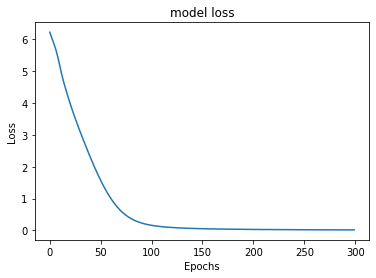

In [263]:
import matplotlib.pyplot as plt
plt.plot(loss_list)
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.show()

## Print five most similar words with the word "delicious"

The whole point of traiing an embedding model is to get an embedding vector for each word. The idea is that the vector somehow captures the meaning of the word. This is useful because data scientists often face scenarios where they must derive meaning from unstructured text data.

Once your model has been trained, you can access the embedding vectors through `model.embedding.weight.data`. You can convert these vectors to a numpy matrix or numpy arrays if needed.

Find the five most similar words with the word "delicious" by calculating cosine similarity between the embedding vector of "delicious" and the embedding vectors of all other words in the vocabulary. 

Hint: cosine similarity is a common metric so you should be able to find one that you can use in an existing library. 

In [0]:
# Insert your code here
from sklearn.metrics.pairwise import cosine_similarity
dd = model.embedding.weight.data
dd = dd.cpu().detach().numpy()
dd_p = pd.DataFrame(dd)
result = pd.DataFrame(cosine_similarity(dd_p, dd_p))
delicious_index = word_to_index["delicious"]
top_6 = result[delicious_index].sort_values(ascending = False).iloc[0:6].index
# list(word_to_index.keys())[371]
# find the 

In [265]:
list(list(word_to_index.keys())[i] for i in top_6)

['delicious', 'delight', 'lot', 'sever', 'after', 'wave']

The five most similar words to `delicious` are `delight`, `lot`, `server`, `after`, `wave`

While the model learns embedding vectors (that best predict the focal word from its contexts), the vectors that it learns don't seem to truly capture the meaning of words. However, this is mainly due to the small size of our training data. Google trained a word2vec model based on large-scale data (about 100 billion words), and this model captures similarity between words well. You can find the pretrained model at https://code.google.com/archive/p/word2vec/.